<a href="https://colab.research.google.com/github/SriVidyaYeluripati/24WS-mmd-code-public/blob/main/SINDy_1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 SINDy in Ground Truth Coordinates z


## 1.1 Simulation

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lasso
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    rhs = np.zeros_like(zt)
    for coef, term in zip(coefficients, terms):
        rhs += coef * term(zt, dzt)
    return rhs

In [ ]:
def pendulum_ode_step(y, t, coefficients, terms):
    z, dz = y
    ddz = pendulum_rhs(z, dz, coefficients, terms)
    return [dz, ddz]

In [ ]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.arange(0, T, dt)
    y0 = [z0, dz0]
    trajectory = odeint(pendulum_ode_step, y0, t, args=(coefficients, terms))
    z_t = trajectory[:, 0]
    dz_t = trajectory[:, 1]
    ddz_t = pendulum_rhs(z_t, dz_t, coefficients, terms)
    return z_t, dz_t, ddz_t, t

In [ ]:
def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding=None, rejection=True):
    z0_values = []
    dz0_values = []
    z_data = []
    dz_data = []
    ddz_data = []

    for _ in range(N):
        while True:
            z0 = np.random.uniform(z0_min, z0_max)
            dz0 = np.random.uniform(dz0_min, dz0_max)
            energy_diff = dz0**2 / 2 - np.cos(z0)
            if not rejection or abs(energy_diff) < 0.99:
                break

        z_t, dz_t, ddz_t, _ = simulate_pendulum(z0, dz0, coefficients, terms, T, dt)
        z0_values.append(z0)
        dz0_values.append(dz0)
        z_data.append(z_t)
        dz_data.append(dz_t)
        ddz_data.append(ddz_t)

    return np.array(z_data), np.array(dz_data), np.array(ddz_data)

In [ ]:
def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding=None, rejection=True):
    z0_values = []
    dz0_values = []
    z_data = []
    dz_data = []
    ddz_data = []

    for _ in range(N):
        attempts = 0  # To track how many attempts are made to generate data
        while True:
            z0 = np.random.uniform(z0_min, z0_max)
            dz0 = np.random.uniform(dz0_min, dz0_max)
            energy_diff = dz0**2 / 2 - np.cos(z0)
            if not rejection or abs(energy_diff) < 0.99:  # Ensure the energy constraint is met
                break
            attempts += 1
            if attempts > 100:  # Avoid infinite loops
                print(f"Warning: Could not generate valid data for z0={z0}, dz0={dz0}")
                break

        if attempts <= 100:  # Only append valid data
            z_t, dz_t, ddz_t, _ = simulate_pendulum(z0, dz0, coefficients, terms, T, dt)
            z0_values.append(z0)
            dz0_values.append(dz0)
            z_data.append(z_t)
            dz_data.append(dz_t)
            ddz_data.append(ddz_t)

    return np.array(z_data), np.array(dz_data), np.array(ddz_data)


In [ ]:
N = 100
z0_min, z0_max = -np.pi, np.pi
dz0_min, dz0_max = -2.1, 2.1
T = 50
dt = 0.02

terms = [lambda z, dz: np.sin(z)]
coefficients = [-1.0]

z_data, dz_data, ddz_data = create_pendulum_data(
    z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N
)

In [ ]:

print("Shapes:", z_data.shape, dz_data.shape, ddz_data.shape)


Shapes: (100, 2500) (100, 2500) (100, 2500)


In [ ]:
def visualize_pendulum(z_data, dz_data, ddz_data, dt, num_samples=5):
    time = np.arange(0, z_data.shape[1] * dt, dt)
    for i in range(num_samples):
        plt.figure(figsize=(10, 6))
        plt.plot(time, z_data[i], label="z(t)")
        plt.plot(time, dz_data[i], label="z˙(t)")
        plt.plot(time, ddz_data[i], label="z¨(t)")
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Value")
        plt.title(f"Pendulum Simulation {i+1}")
        plt.show()

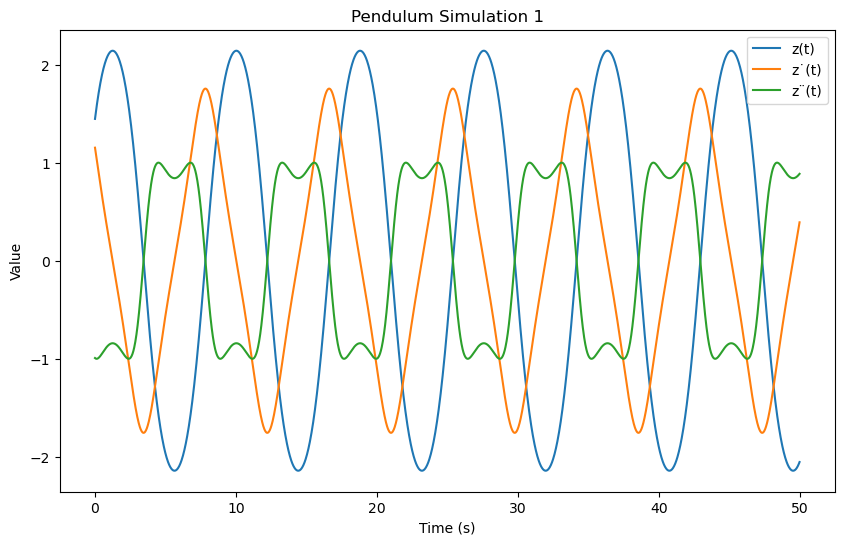

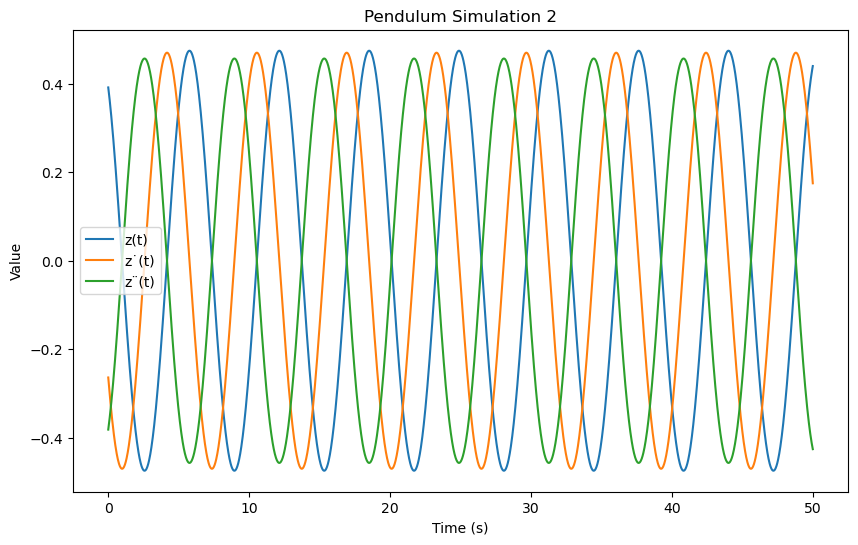

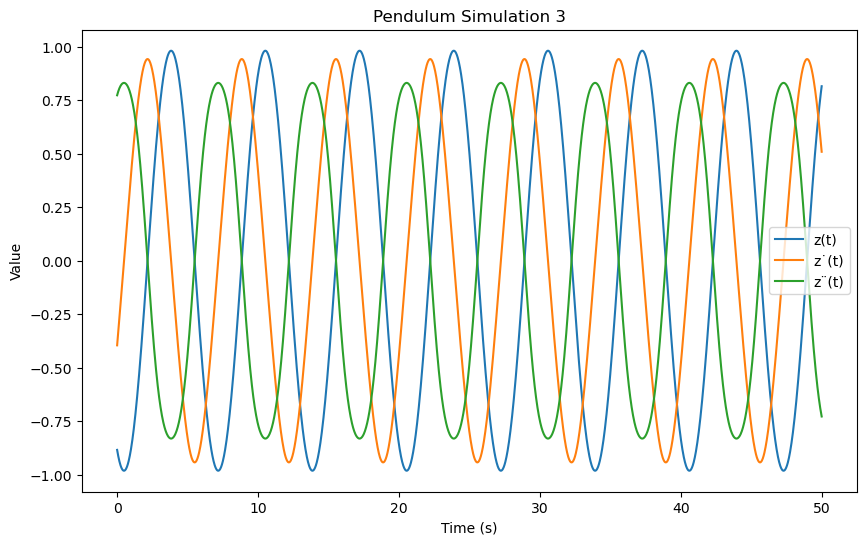

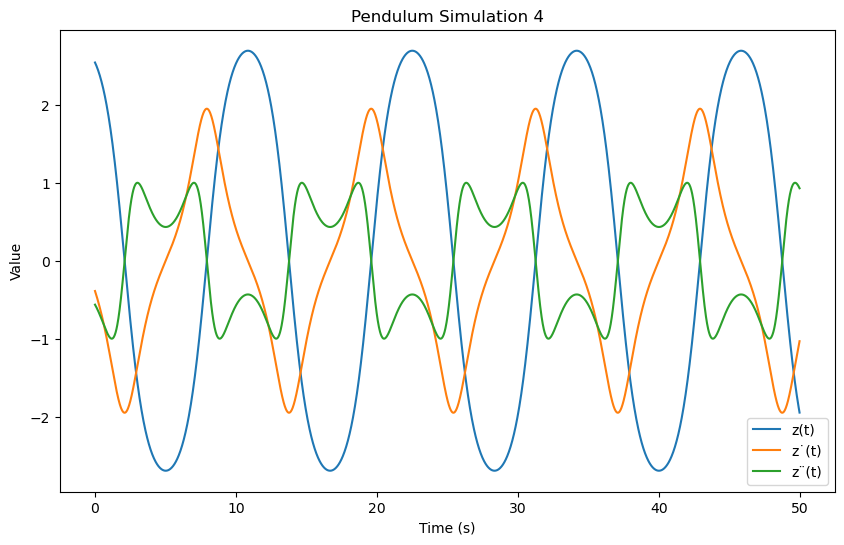

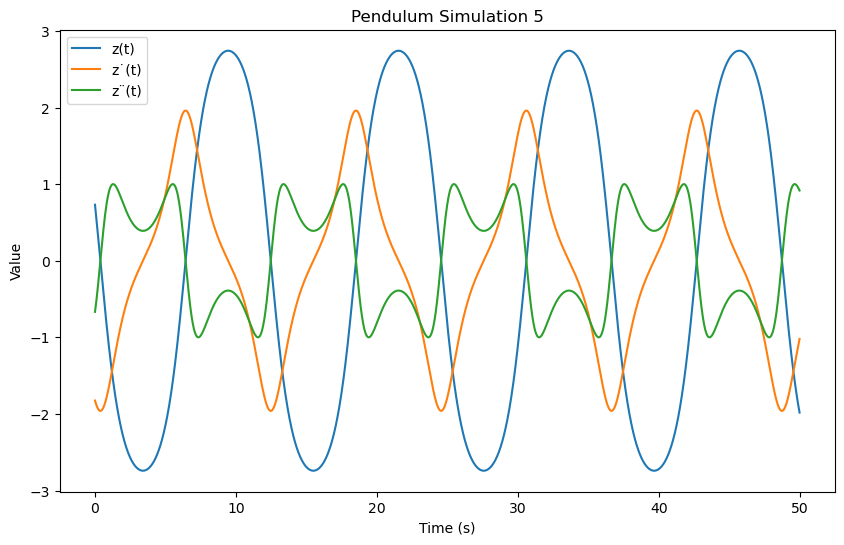

In [ ]:
visualize_pendulum(z_data, dz_data, ddz_data, dt)

In [ ]:
## Normalize data
def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

z_data = normalize_data(z_data)
dz_data = normalize_data(dz_data)
ddz_data = normalize_data(ddz_data)

## 1.2 Implementation & Training

In [ ]:
terms = [
    lambda z, dz: np.ones_like(z),
    lambda z, dz: z,
    lambda z, dz: dz,
    lambda z, dz: np.sin(z),
    lambda z, dz: z**2,
    lambda z, dz: z*dz,
    lambda z, dz: z*np.sin(z),
    lambda z, dz: dz**2,
    lambda z, dz: dz* np.sin(z),
    lambda z, dz: (np.sin(z))**2
]

def construct_design_matrix(z, dz, terms):
  return np.column_stack([term(z, dz) for term in terms])

First version of solver: using the sklearn.linear_model.Lasso class

In [ ]:
from sklearn.linear_model import LassoCV

def fit_lasso(z, dz, ddz, terms):
    theta = construct_design_matrix(z, dz, terms)
    model = LassoCV(cv=5, alphas=np.logspace(-4, 0, 50), max_iter=10000).fit(theta, ddz)
    return model.coef_


In [ ]:
#lambda_reg = 0.5
#coefficients = fit_lasso(z_data, dz_data, ddz_data, terms, lambda_reg)

#print("Learned coefficients (Xi):", coefficients)


# #Using the linear CV model
# from sklearn.linear_model import LassoCV

# #Lasso Cross validation
# lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=0).fit(X_train, y_train)


# #score
# print(lasso_cv.score(X_train, y_train))
# print(lasso_cv.score(X_test, y_test))
coefficients = fit_lasso(z_data.flatten(), dz_data.flatten(), ddz_data.flatten(), terms)

print("Learned coefficients (Xi):", coefficients)


Learned coefficients (Xi): [ 0.00000000e+00  8.73004671e-01  0.00000000e+00 -2.61112213e+00
 -7.99839421e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


Now a pytorch version:

In [ ]:
class SINDy(nn.Module):
  def __init__(self, terms):
    super(SINDy, self).__init__()
    self.terms = terms
    self.coefficients = nn.Parameter(torch.ones(len(terms)))
    self.mask = torch.ones(len(terms),dtype=torch.bool)

  def forward(self, z, dz):
    # compute Θ(z, dz) · (Ξ)
    Theta = torch.stack([torch.tensor(term(z, dz), dtype=torch.float32) for term in self.terms], dim=-1)

    active_coeff = self.coefficients * self.mask.float()

    return torch.matmul(Theta, active_coeff)


def train_sindy(model, z, dz, ddz, lambda_reg, epochs, lr):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    optimizer.zero_grad()

    predicted_ddz = model(z, dz)

    mse_loss = torch.mean((predicted_ddz - torch.tensor(ddz))**2)
    l1_reqularization = lambda_reg * torch.sum(torch.abs(model.coefficients))
    loss = mse_loss + l1_reqularization

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
      print(f"-->Epoch {epoch}, Loss: {loss.item()}, Coefficients: {model.coefficients.data.numpy()}, Mask: {model.mask.data.numpy()}")



sindy_model = SINDy(terms)
train_sindy(sindy_model, z_data, dz_data, ddz_data, lambda_reg=0.1, epochs=1000, lr=0.01)

-->Epoch 0, Loss: 31.607473640226395, Coefficients: [0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99], Mask: [ True  True  True  True  True  True  True  True  True  True]
-->Epoch 50, Loss: 10.73922231835066, Coefficients: [0.52832586 0.51302725 0.5266431  0.51198405 0.528495   0.5266449
 0.5282679  0.52836466 0.5260805  0.5279695 ], Mask: [ True  True  True  True  True  True  True  True  True  True]
-->Epoch 100, Loss: 2.7938768699014336, Coefficients: [0.21662566 0.12439277 0.20658126 0.11754932 0.2178436  0.2068066
 0.21621615 0.21688747 0.2028298  0.21409054], Mask: [ True  True  True  True  True  True  True  True  True  True]
-->Epoch 150, Loss: 0.7462576296983335, Coefficients: [ 0.0609278  -0.14847082  0.0385548  -0.1624528   0.06450713  0.04004344
  0.05974601  0.06163067  0.0284788   0.05355519], Mask: [ True  True  True  True  True  True  True  True  True  True]
-->Epoch 200, Loss: 0.3417339402475379, Coefficients: [ 4.7766129e-03 -3.1444675e-01  9.2546665e-04 -3.3831596e-0

## 1.3 Thresholding

In [ ]:
def train_sindy_with_thresholding(model, z, dz, ddz, lambda_reg, epochs, lr, thresholding=None, a=0.1, b=0.01, P=10, S=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    coefficients_history = []

    if thresholding == "sequential" or thresholding == "patient":
        model.mask = torch.ones(len(model.coefficients), dtype=torch.bool)
    if thresholding == "patient":
        prev_coeff = torch.zeros_like(model.coefficients)
        Ea = torch.zeros_like(model.coefficients, dtype=torch.long)
        Eb = torch.zeros_like(model.coefficients, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predicted_ddz = model(z, dz)
        mse_loss = torch.mean((predicted_ddz - torch.tensor(ddz))**2)
        l1_regularization = lambda_reg * torch.sum(torch.abs(model.coefficients))
        loss = mse_loss + l1_regularization
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        coefficients_history.append(model.coefficients.data.clone().numpy())

        if thresholding == "sequential" and epoch % S == 0:
            model.coefficients.data[torch.abs(model.coefficients) < a] = 0
            model.mask[torch.abs(model.coefficients) < a] = False
        elif thresholding == "patient":
            Ea[torch.abs(model.coefficients) > a] = epoch
            Eb[torch.abs(model.coefficients - prev_coeff) > b] = epoch

            temp_mask = ((epoch - Ea) < P) | ((epoch - Eb) < P)
            model.mask = model.mask & temp_mask
            prev_coeff = model.coefficients.clone().detach()

        model.coefficients.data *= model.mask.float()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Coefficients: {model.coefficients.data.numpy()}")

    return loss_history, coefficients_history

## 1.4. Evaluation & Visualization

In [ ]:
sindy_model = SINDy(terms)
loss_history, coefficients_history = train_sindy_with_thresholding(
    sindy_model, z_data, dz_data, ddz_data, lambda_reg=0.1, epochs=1000, lr=0.001,
    thresholding="patient", a=0.1, b=0.01, P=10
)


Epoch 0, Loss: 31.607473640226395, Coefficients: [0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999]
Epoch 50, Loss: 28.83668002331404, Coefficients: [0.9493181  0.94920456 0.9493063  0.94919604 0.94931936 0.9493063
 0.94931793 0.94931835 0.9493026  0.94931585]
Epoch 100, Loss: 26.250713752653937, Coefficients: [0.9007633  0.9001282  0.900697   0.9000824  0.90076995 0.90069693
 0.9007614  0.9007651  0.9006754  0.90075004]
Epoch 150, Loss: 23.84809094106016, Coefficients: [0.85347545 0.85185367 0.85330534 0.8517375  0.8534922  0.8533052
 0.85347015 0.8534796  0.8532495  0.8534409 ]
Epoch 200, Loss: 21.620274894119813, Coefficients: [0.8074683  0.80438304 0.8071441  0.80416197 0.8075005  0.8071439
 0.8074577  0.8074759  0.8070365  0.80740154]
Epoch 250, Loss: 19.55875394114387, Coefficients: [0.7627538  0.75771785 0.7622234  0.7573557  0.7628069  0.7622237
 0.76273584 0.7627661  0.7620459  0.7626429 ]
Epoch 300, Loss: 17.655160630165554, Coefficients: [0.7193436  0.71185935 0.7

In [ ]:
print("Final Coefficients:", sindy_model.coefficients.data.numpy())
print("Final Mask (Υ):", sindy_model.mask.data.numpy())

Final Coefficients: [0.25428852 0.15680215 0.2440235  0.14886726 0.25565797 0.24439725
 0.253831   0.25457275 0.23993407 0.25144914]
Final Mask (Υ): [ True  True  True  True  True  True  True  True  True  True]


As observed, the final coefficients do not isolate a dominant term like sin(z), as they are all non-zero and relatively similar in magnitude. This suggests that the model is not confidently identifying the most relevant terms for the system dynamics. Additionally, the mask (Υ) retains all terms (True for all entries), indicating that thresholding did not prune the less significant terms effectively. Further refinement of the training process, such as adjusting the thresholding parameters (a, b) or regularization strength (lambda_reg), may help improve term selection.
Let's plot loss and coefficient history:

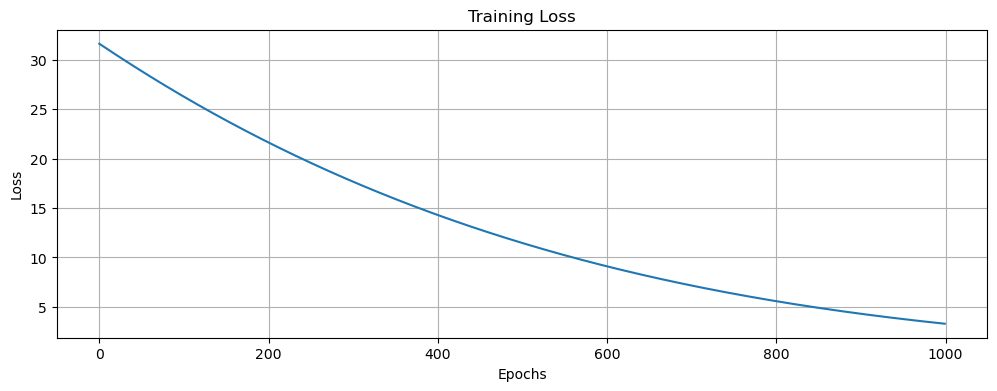

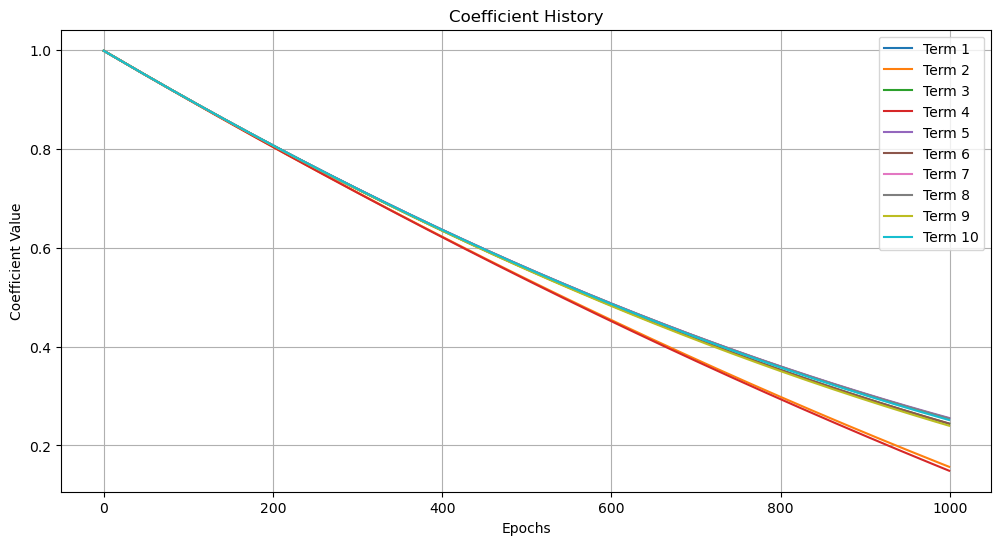

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

coefficients_history = np.array(coefficients_history)
plt.figure(figsize=(12, 6))
for i in range(coefficients_history.shape[1]):
    plt.plot(coefficients_history[:, i], label=f"Term {i+1}")
plt.xlabel("Epochs")
plt.ylabel("Coefficient Value")
plt.title("Coefficient History")
plt.legend()
plt.grid()
plt.show()

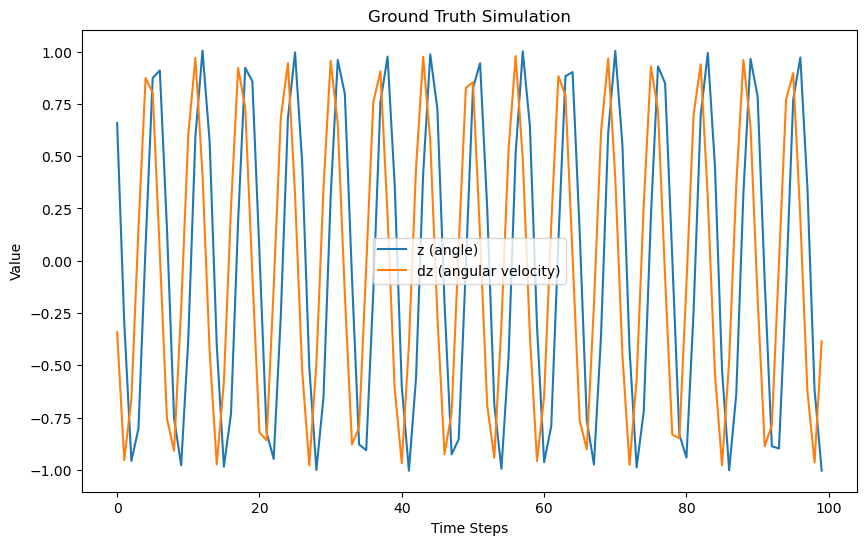

In [ ]:
## 1.4 Ground Truth Simulation
def simulate_ground_truth(initial_conditions, time_steps):
    z, dz = initial_conditions
    trajectory = []
    for t in range(time_steps):
        ddz = -np.sin(z)
        dz = np.add(dz, ddz)
        z = np.add(z, dz)
        trajectory.append([z, dz])
    return np.array(trajectory)

test_initial_conditions = np.array([1.0, 0.5])
time_steps = 100
ground_truth = simulate_ground_truth(test_initial_conditions, time_steps)
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), ground_truth[:, 0], label="z (angle)")
plt.plot(range(time_steps), ground_truth[:, 1], label="dz (angular velocity)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Ground Truth Simulation")
plt.legend()
plt.show()

## 1.5 Small Angle Approximation

Shape of small_angle_data: (5, 2500, 3)


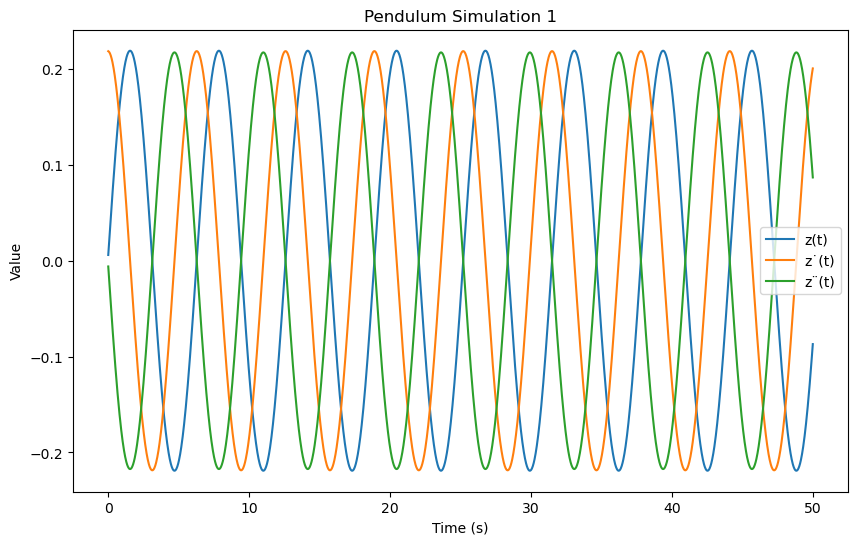

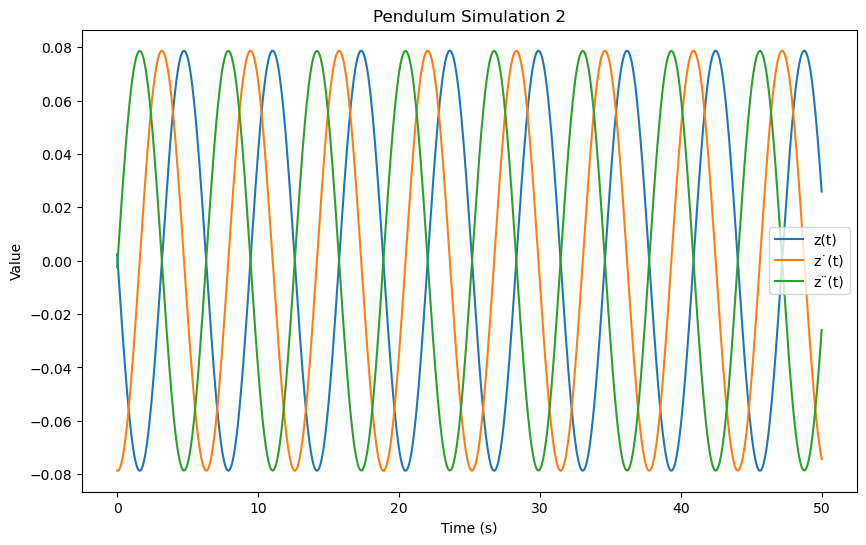

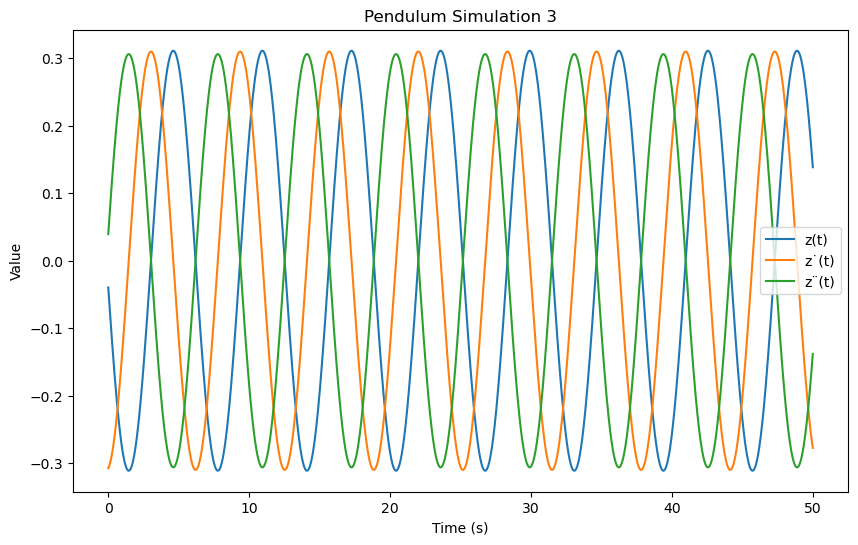

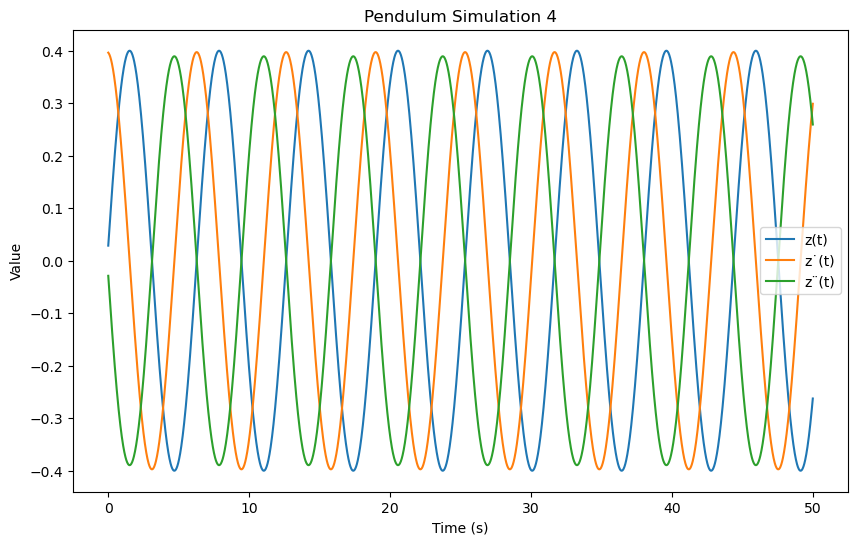

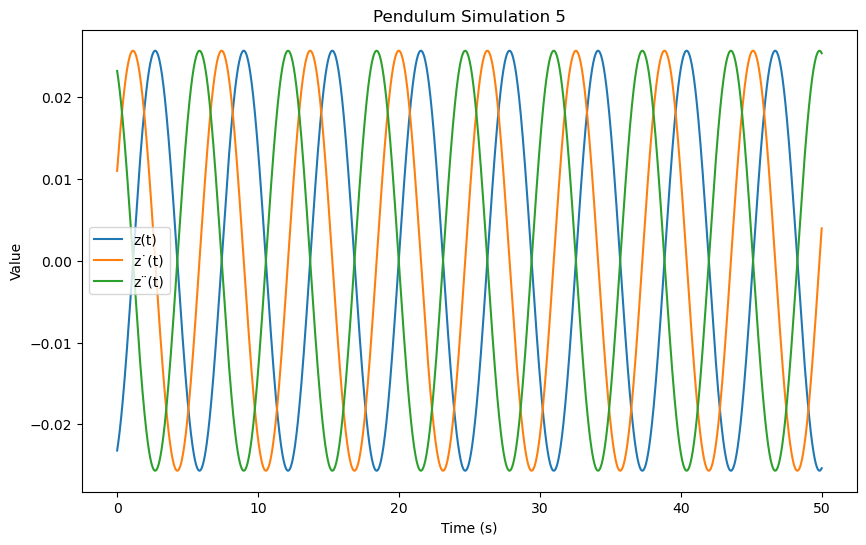

In [ ]:
## 1.5 Small Angle Approximation
terms_small = [lambda z, dz: np.sin(z)]
coefficients_small = np.array([-1.0])

def simulate_small_angle(z0_min, z0_max, dz0_min, dz0_max, T, dt, N):
    z_data, dz_data, ddz_data = create_pendulum_data(
        z0_min, z0_max, dz0_min, dz0_max, coefficients_small, terms_small, T, dt, N, rejection=False
    )
    # Stack the data along the third dimension
    return np.stack((z_data, dz_data, ddz_data), axis=-1)



z0_min_small, z0_max_small = -np.pi / 36, np.pi / 36
dz0_min_small, dz0_max_small = -0.5, 0.5
small_angle_data = simulate_small_angle(z0_min_small, z0_max_small, dz0_min_small, dz0_max_small, 50, 0.02, 5)

print("Shape of small_angle_data:", small_angle_data.shape)


visualize_pendulum(
    small_angle_data[:, :, 0],  # z_data
    small_angle_data[:, :, 1],  # dz_data
    small_angle_data[:, :, 2],  # ddz_data
    dt
)



All five simulations exhibit stable periodic behavior, characteristic of harmonic motion.
The periodicity and amplitudes are consistent, indicating proper implementation of the small-angle approximation.
The angular displacement, velocity, and acceleration are phase-shifted as expected in harmonic motion.

# 2 SINDy-Autoencoder
## 2.1 Cartesian Embedding

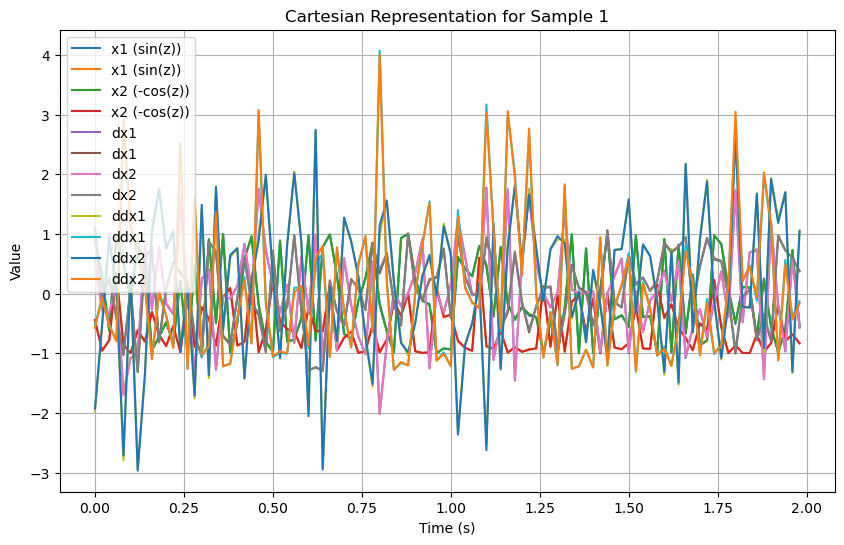

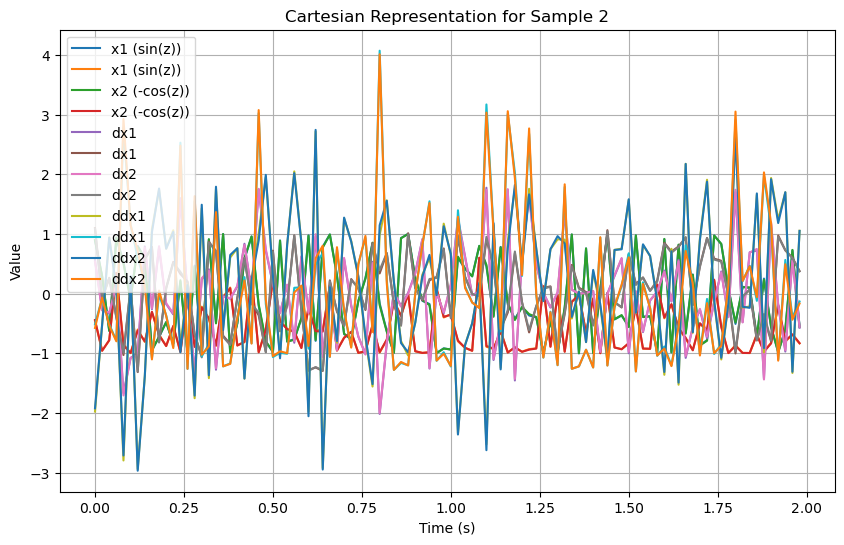

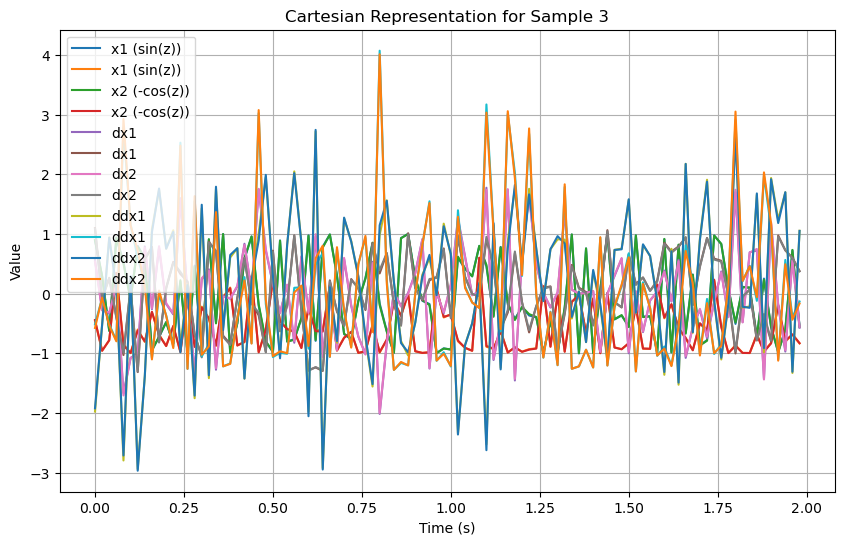

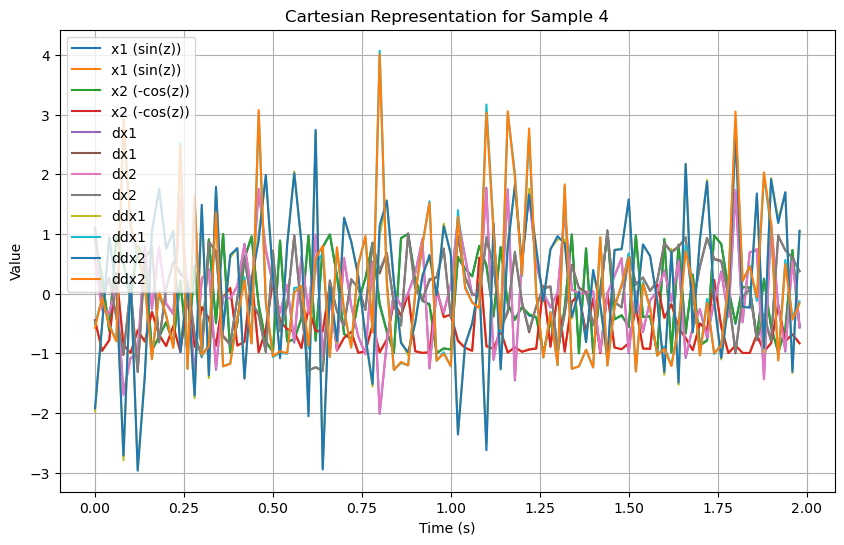

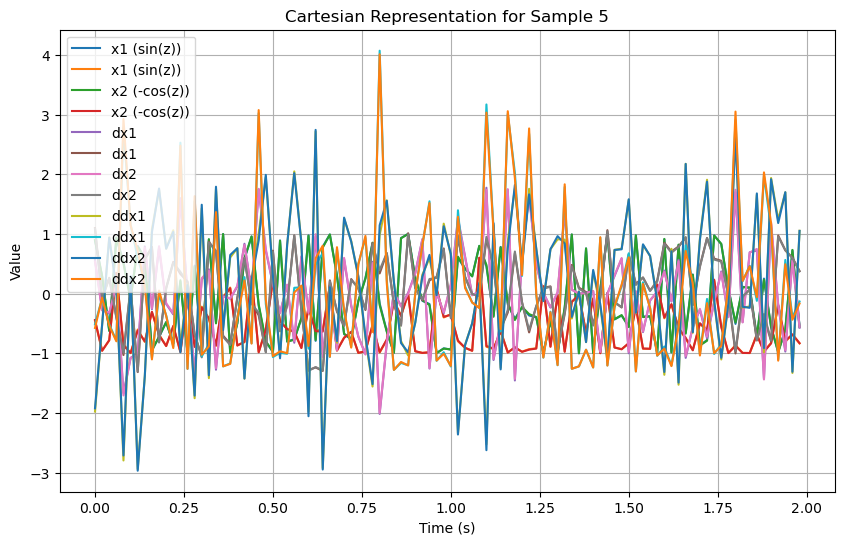

In [ ]:
def embed_cartesian(z, dz, ddz):
    """
    Embeds the pendulum data into Cartesian coordinates.
    Args:
        z (ndarray): Angular positions.
        dz (ndarray): Angular velocities.
        ddz (ndarray): Angular accelerations.
    Returns:
        x, dx, ddx: Cartesian positions, velocities, and accelerations.
    """
    x = np.stack([np.sin(z), -np.cos(z)], axis=-1)  # Positions
    dx = np.stack([np.cos(z) * dz, np.sin(z) * dz], axis=-1)  # Velocities
    ddx = np.stack([
        -np.sin(z) * dz**2 + np.cos(z) * ddz,
        np.cos(z) * dz**2 + np.sin(z) * ddz
    ], axis=-1)  # Accelerations
    return x, dx, ddx

# Generate Cartesian data
x_data, dx_data, ddx_data = embed_cartesian(z_data, dz_data, ddz_data)

# Visualization (from previous task)
def visualize_cartesian(x, dx, ddx, dt, num_samples=5):
    time = np.arange(0, x.shape[0] * dt, dt)
    for i in range(num_samples):
        plt.figure(figsize=(10, 6))
        plt.plot(time, x[:, 0], label="x1 (sin(z))")
        plt.plot(time, x[:, 1], label="x2 (-cos(z))")
        plt.plot(time, dx[:, 0], label="dx1")
        plt.plot(time, dx[:, 1], label="dx2")
        plt.plot(time, ddx[:, 0], label="ddx1")
        plt.plot(time, ddx[:, 1], label="ddx2")
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Value")
        plt.title(f"Cartesian Representation for Sample {i+1}")
        plt.grid()
        plt.show()

visualize_cartesian(x_data, dx_data, ddx_data, dt)

## 2.2 Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z


# Define a function for hyperparameter optimization
def optimize_autoencoder(x_data, hidden_dims_grid, latent_dims, learning_rate=1e-3, epochs=100, batch_size=32):
    """
    Optimizes the autoencoder hyperparameters.
    Args:
        x_data (ndarray): Cartesian position data (x).
        hidden_dims_grid (list of lists): Different configurations for hidden layer dimensions.
        latent_dims (list): Latent space dimensionality to search over.
        learning_rate (float): Learning rate for Adam optimizer.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
    Returns:
        best_model (Autoencoder): Best-performing autoencoder.
        best_loss (float): Lowest validation loss achieved.
        best_params (dict): Best hyperparameter configuration.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)

    # Flatten x_data if needed
    x_data = x_data.view(len(x_data), -1)

    # Split data into train and validation sets
    train_size = int(0.8 * len(x_data))
    val_size = len(x_data) - train_size
    train_data, val_data = torch.utils.data.random_split(x_data, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Hyperparameter search
    param_grid = ParameterGrid({"hidden_dims": hidden_dims_grid, "latent_dim": latent_dims})
    best_loss = float("inf")
    best_model = None
    best_params = None

    for params in param_grid:
        model = Autoencoder(input_dim=x_data.shape[1], hidden_dims=params["hidden_dims"], latent_dim=params["latent_dim"]).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                x_reconstructed, _ = model(batch)
                loss = criterion(x_reconstructed, batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)

        # Validate the model
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x_reconstructed, _ = model(batch)
                loss = criterion(x_reconstructed, batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Check for the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = params

        print(f"Params: {params}, Validation Loss: {val_loss:.4f}")

    return best_model, best_loss, best_params


# Define hyperparameter grids
hidden_dims_grid = [[64, 32], [128, 64, 32], [256, 128, 64]]
latent_dims = [2, 4, 8]

# Optimize the autoencoder
best_model, best_loss, best_params = optimize_autoencoder(
    x_data, hidden_dims_grid, latent_dims, learning_rate=1e-3, epochs=50, batch_size=64
)

print(f"Best Params: {best_params}, Best Validation Loss: {best_loss:.4f}")

Params: {'hidden_dims': [64, 32], 'latent_dim': 2}, Validation Loss: 0.2147
Params: {'hidden_dims': [64, 32], 'latent_dim': 4}, Validation Loss: 0.1835
Params: {'hidden_dims': [64, 32], 'latent_dim': 8}, Validation Loss: 0.1725
Params: {'hidden_dims': [128, 64, 32], 'latent_dim': 2}, Validation Loss: 0.2081
Params: {'hidden_dims': [128, 64, 32], 'latent_dim': 4}, Validation Loss: 0.1883
Params: {'hidden_dims': [128, 64, 32], 'latent_dim': 8}, Validation Loss: 0.1699
Params: {'hidden_dims': [256, 128, 64], 'latent_dim': 2}, Validation Loss: 0.2085
Params: {'hidden_dims': [256, 128, 64], 'latent_dim': 4}, Validation Loss: 0.1283
Params: {'hidden_dims': [256, 128, 64], 'latent_dim': 8}, Validation Loss: 0.1227
Best Params: {'hidden_dims': [256, 128, 64], 'latent_dim': 8}, Best Validation Loss: 0.1227


## 2.3 Propagation of Time Derivatives

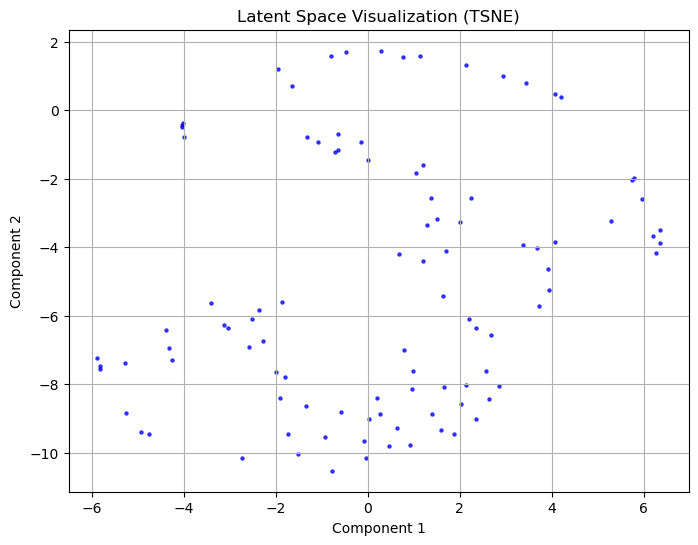

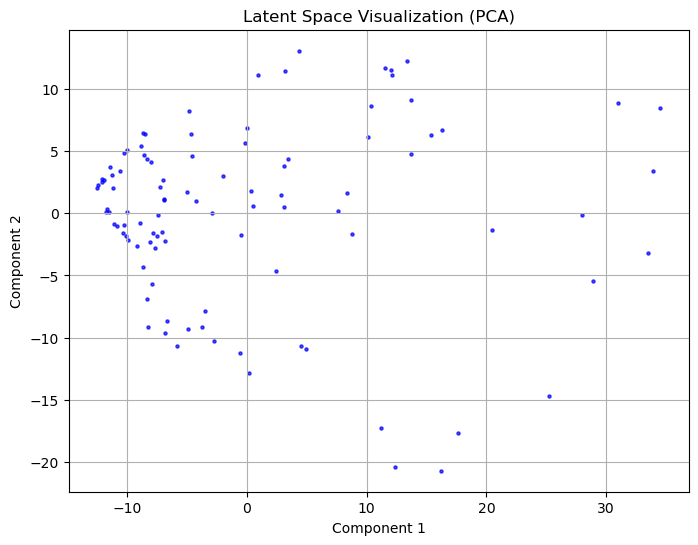

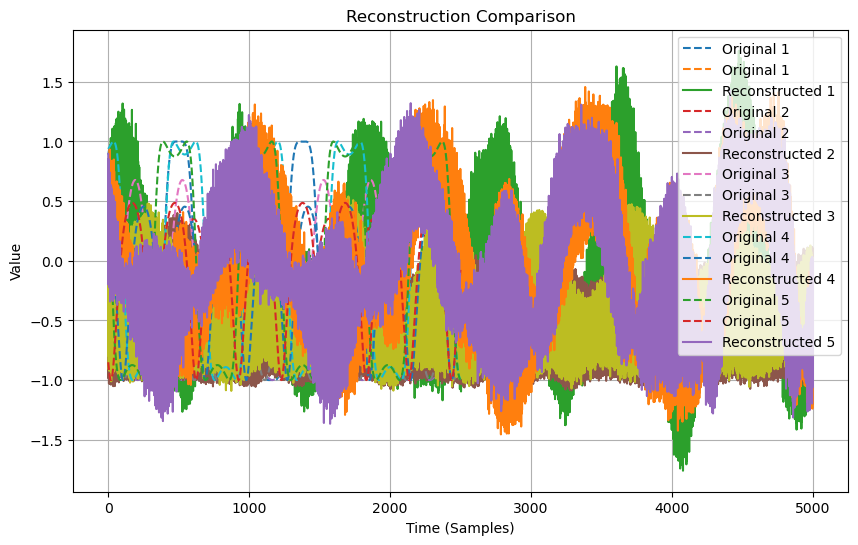

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def evaluate_autoencoder(autoencoder, x_data):
    """
    Evaluates the autoencoder's latent representation and reconstruction.
    Args:
        autoencoder (Autoencoder): Trained autoencoder model.
        x_data (ndarray): Cartesian data used for evaluation.
    Returns:
        latent_representation (ndarray): Latent representation of the input data.
        reconstructed_data (ndarray): Reconstructed input data.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    x_data = x_data.view(len(x_data), -1)

    autoencoder.eval()
    with torch.no_grad():
        reconstructed_data, latent_representation = autoencoder(x_data)
    return latent_representation.cpu().numpy(), reconstructed_data.cpu().numpy()

def visualize_latent_space(latent_representation, method="tsne"):
    """
    Visualizes the latent space using t-SNE or PCA.
    Args:
        latent_representation (ndarray): Latent representation of the data.
        method (str): Dimensionality reduction method ("tsne" or "pca").
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")

    reduced_latent = reducer.fit_transform(latent_representation)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.7, s=5, c="blue")
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

def visualize_reconstruction(original_data, reconstructed_data, num_samples=5):
    """
    Visualizes the original and reconstructed data.
    Args:
        original_data (ndarray): Original input data.
        reconstructed_data (ndarray): Reconstructed data from the autoencoder.
        num_samples (int): Number of samples to visualize.
    """
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(original_data[i], label=f"Original {i+1}", linestyle="dashed")
        plt.plot(reconstructed_data[i], label=f"Reconstructed {i+1}")
    plt.title("Reconstruction Comparison")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


# Evaluate the best autoencoder
latent_representation, reconstructed_data = evaluate_autoencoder(best_model, x_data)

# Visualize the latent space using t-SNE
visualize_latent_space(latent_representation, method="tsne")

# Visualize the latent space using PCA
visualize_latent_space(latent_representation, method="pca")

# Visualize the reconstruction quality
visualize_reconstruction(x_data, reconstructed_data, num_samples=5)

## 2.4 Implementation

In [ ]:
class SINDyAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, terms):
        super(SINDyAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        # SINDy model
        self.sindy = SINDy(terms)

    def forward(self, x, dx, ddx):
        # Encode input
        z = self.encoder(x)
        dz = self.encoder(dx)  # First derivative in latent space
        ddz = self.encoder(ddx)  # Second derivative in latent space

        # Predict RHS in latent space using SINDy
        predicted_ddz = self.sindy(z, dz)

        # Decode back to original space
        reconstructed_x = self.decoder(z)
        reconstructed_ddx = self.decoder(predicted_ddz)

        return reconstructed_x, z, dz, ddz, reconstructed_ddx

## 2.5 Refinement

In [ ]:
def train_sindy_autoencoder(model, data, dx_data, ddx_data, optimizer, epochs, criterion, refinement_start, lambda_ddz, lambda_ddx, lambda_l1):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        reconstructed_x, z, dz, ddz, reconstructed_ddx = model(data, dx_data, ddx_data)

        # Losses
        reconstruction_loss = criterion(reconstructed_x, data)
        latent_derivative_loss = lambda_ddz * criterion(ddz, model.sindy(z, dz))
        reconstructed_derivative_loss = lambda_ddx * criterion(ddx_data, reconstructed_ddx)

        # L1 regularization (only before refinement starts)
        if epoch < refinement_start:
            l1_regularization = lambda_l1 * torch.sum(torch.abs(model.sindy.coefficients))
        else:
            l1_regularization = 0

        total_loss = reconstruction_loss + latent_derivative_loss + reconstructed_derivative_loss + l1_regularization
        total_loss.backward()
        optimizer.step()

        # Logging progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {total_loss.item():.6f}, "
                  f"Reconstruction Loss = {reconstruction_loss.item():.6f}, "
                  f"Latent Derivative Loss = {latent_derivative_loss.item():.6f}, "
                  f"Reconstructed Derivative Loss = {reconstructed_derivative_loss.item():.6f}")

## 2.6 Training

In [ ]:
device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")

terms = [
    lambda z, dz: torch.ones_like(z),       # Constant term
    lambda z, dz: z,                        # Linear term
    lambda z, dz: dz,                       # Derivative term
    lambda z, dz: torch.sin(z),             # Sine term
    lambda z, dz: z**2,                     # Quadratic term
    lambda z, dz: z * dz,                   # Interaction term
    lambda z, dz: z * torch.sin(z),         # Mixed sine term
    lambda z, dz: dz**2,                    # Quadratic derivative term
    lambda z, dz: dz * torch.sin(z),        # Derivative-sine interaction
    lambda z, dz: torch.sin(z)**2           # Sine squared term
]

In [ ]:
# Ensure input data is a torch.Tensor and moved to the correct device
x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
dx_data = torch.tensor(dx_data, dtype=torch.float32).to(device)
ddx_data = torch.tensor(ddx_data, dtype=torch.float32).to(device)

# Define training parameters
epochs = 5000
refinement_start = 4000
lambda_ddz = 5e-5
lambda_ddx = 5e-4
lambda_l1 = 1e-5

# Initialize the model and optimizer
sindy_autoencoder = SINDyAutoencoder(input_dim=2, latent_dim=2, terms=terms).to(device)
optimizer = optim.Adam(sindy_autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train the model
train_sindy_autoencoder(
    sindy_autoencoder,
    x_data, dx_data, ddx_data,
    optimizer,
    epochs,
    criterion,
    refinement_start,
    lambda_ddz,
    lambda_ddx,
    lambda_l1
)

C:\Users\Grace\AppData\Local\Temp\ipykernel_30032\750802231.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Theta = torch.stack([torch.tensor(term(z, dz), dtype=torch.float32) for term in self.terms], dim=-1)


Epoch 0: Total Loss = 0.384710, Reconstruction Loss = 0.383496, Latent Derivative Loss = 0.000059, Reconstructed Derivative Loss = 0.001054
Epoch 100: Total Loss = 0.005462, Reconstruction Loss = 0.000602, Latent Derivative Loss = 0.001811, Reconstructed Derivative Loss = 0.002962
Epoch 200: Total Loss = 0.002693, Reconstruction Loss = 0.000063, Latent Derivative Loss = 0.001669, Reconstructed Derivative Loss = 0.000882
Epoch 300: Total Loss = 0.001963, Reconstruction Loss = 0.000018, Latent Derivative Loss = 0.001268, Reconstructed Derivative Loss = 0.000604
Epoch 400: Total Loss = 0.001587, Reconstruction Loss = 0.000010, Latent Derivative Loss = 0.000970, Reconstructed Derivative Loss = 0.000539
Epoch 500: Total Loss = 0.001294, Reconstruction Loss = 0.000007, Latent Derivative Loss = 0.000732, Reconstructed Derivative Loss = 0.000493
Epoch 600: Total Loss = 0.001076, Reconstruction Loss = 0.000006, Latent Derivative Loss = 0.000559, Reconstructed Derivative Loss = 0.000454
Epoch 70

## 2.7 Evaluation & Visualization

C:\Users\Grace\AppData\Local\Temp\ipykernel_30032\990137792.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
C:\Users\Grace\AppData\Local\Temp\ipykernel_30032\990137792.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dx_data = torch.tensor(dx_data, dtype=torch.float32).to(device)
C:\Users\Grace\AppData\Local\Temp\ipykernel_30032\990137792.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ddx_data = torch.tensor(ddx_data, dtype=torch.float32).to(device)
C:\Users\Grac

Reconstruction MSE: 0.000149
Derivative MSE (ddx): 0.478494
Reconstruction FVU: 0.000361
Derivative FVU: 0.303172


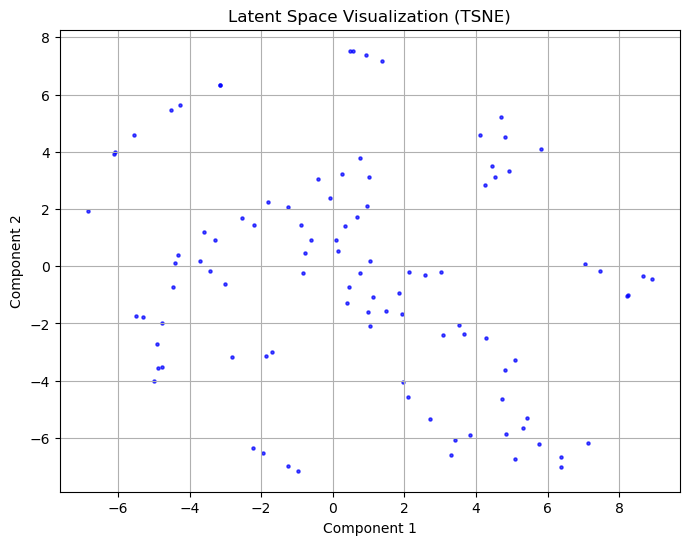

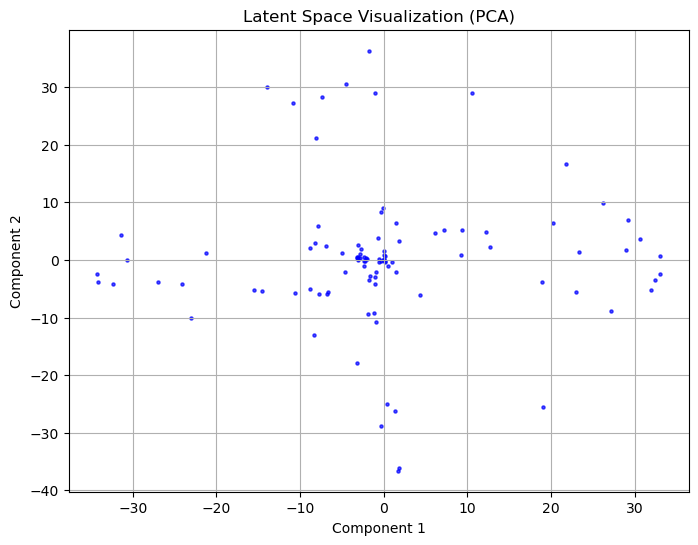

SINDy Sparsity: 100.00%
SINDy Coefficients:
[ 0.9063949   0.34562358  0.05806331  0.40099624  0.09190511 -0.05299692
  0.11906413 -0.0704812   0.40331444  0.16643201]


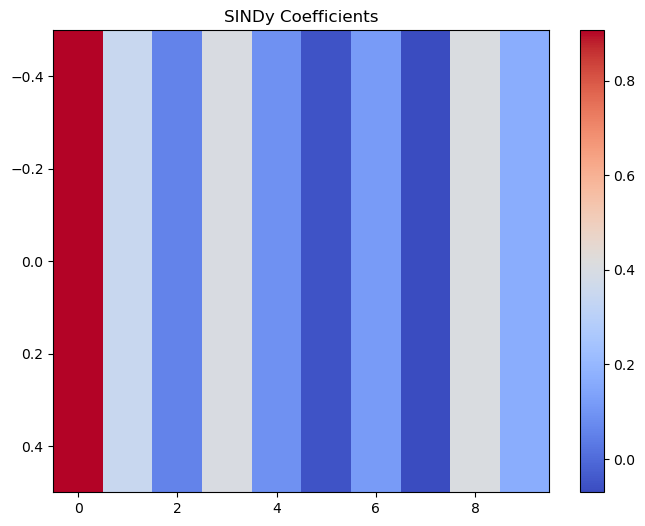

In [ ]:
from sklearn.metrics import mean_squared_error

def evaluate_model(autoencoder, x_data, dx_data, ddx_data):
    """
    Evaluate the SINDyAutoencoder model by calculating reconstruction errors,
    visualizing latent space, and analyzing SINDy sparsity.
    """
    # Switch to evaluation mode
    autoencoder.eval()
    device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure the input tensors are on the correct device
    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    dx_data = torch.tensor(dx_data, dtype=torch.float32).to(device)
    ddx_data = torch.tensor(ddx_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        # Forward pass
        reconstructed_x, z, dz, ddz, reconstructed_ddx = autoencoder(x_data, dx_data, ddx_data)

        # Ensure the tensors have the correct shape
        x_data_reshaped = x_data.view(x_data.shape[0], -1).cpu().numpy()
        reconstructed_x_reshaped = reconstructed_x.view(reconstructed_x.shape[0], -1).cpu().numpy()

        # Reconstruction error
        mse_reconstruction = mean_squared_error(x_data_reshaped, reconstructed_x_reshaped)
        print(f"Reconstruction MSE: {mse_reconstruction:.6f}")

        # Derivative error (ddz)
        ddx_data_reshaped = ddx_data.view(ddx_data.shape[0], -1).cpu().numpy()
        reconstructed_ddx_reshaped = reconstructed_ddx.view(reconstructed_ddx.shape[0], -1).cpu().numpy()
        mse_ddz = mean_squared_error(ddx_data_reshaped, reconstructed_ddx_reshaped)
        print(f"Derivative MSE (ddx): {mse_ddz:.6f}")

        # Fraction of Variance Unexplained (FVU)
        fvu_reconstruction = mse_reconstruction / torch.var(x_data).item()
        fvu_ddz = mse_ddz / torch.var(ddx_data).item()
        print(f"Reconstruction FVU: {fvu_reconstruction:.6f}")
        print(f"Derivative FVU: {fvu_ddz:.6f}")

        return z.cpu().numpy(), reconstructed_x_reshaped, fvu_reconstruction, fvu_ddz

def visualize_latent_space(latent_representation, method="tsne"):
    """
    Visualizes the latent space using t-SNE or PCA.
    Args:
        latent_representation (ndarray): Latent representation of the data.
        method (str): Dimensionality reduction method ("tsne" or "pca").
    """
    # Reshape latent representation to 2D
    if latent_representation.ndim > 2:
        latent_representation = latent_representation.reshape(latent_representation.shape[0], -1)

    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")

    reduced_latent = reducer.fit_transform(latent_representation)

    # Plot the reduced latent space
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.7, s=5, c="blue")
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

def analyze_sindy_coefficients(model):
    """
    Analyzes the sparsity of the SINDy coefficients.
    """
    with torch.no_grad():
        coefficients = model.sindy.coefficients.cpu().numpy()
        active_terms = np.sum(coefficients != 0)
        total_terms = coefficients.size
        sparsity = active_terms / total_terms

        print(f"SINDy Sparsity: {sparsity * 100:.2f}%")
        print("SINDy Coefficients:")
        print(coefficients)

        plt.figure(figsize=(8, 6))
        plt.imshow(coefficients.reshape(1, -1), aspect="auto", cmap="coolwarm")
        plt.colorbar()
        plt.title("SINDy Coefficients")
        plt.show()


# Evaluate the trained model
z, reconstructed_x, fvu_reconstruction, fvu_ddz = evaluate_model(
    sindy_autoencoder, x_data, dx_data, ddx_data
)

# Visualize the latent space
visualize_latent_space(z, method="tsne")
visualize_latent_space(z, method="pca")

# Analyze SINDy coefficients
analyze_sindy_coefficients(sindy_autoencoder)

# 3. SINDy-Autoencoder on Videos
## 3.1 Articial Embedding

In [4]:
# Helper functions for pendulum simulation and embedding
def pendulum_rhs(z, dz, coefficients, terms):
    rhs = np.zeros_like(z)
    for coef, term in zip(coefficients, terms):
        rhs += coef * term(z, dz)
    return rhs

def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.arange(0, T, dt)
    trajectory = np.zeros((len(t), 2))
    trajectory[0, :] = [z0, dz0]

    for i in range(1, len(t)):
        z, dz = trajectory[i - 1]
        ddz = pendulum_rhs(z, dz, coefficients, terms)
        trajectory[i, 0] = z + dz * dt
        trajectory[i, 1] = dz + ddz * dt

    z_t = trajectory[:, 0]
    dz_t = trajectory[:, 1]
    ddz_t = pendulum_rhs(z_t, dz_t, coefficients, terms)
    return z_t, dz_t, ddz_t

def sin_function(z, dz):
    return np.sin(z)

def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding=None, batch_size=10):
    trajectories = []
    for _ in range(N):
        z0 = np.random.uniform(z0_min, z0_max)
        dz0 = np.random.uniform(dz0_min, dz0_max)
        z_t, dz_t, ddz_t = simulate_pendulum(z0, dz0, coefficients, terms, T, dt)
        trajectories.append(np.stack((z_t, dz_t, ddz_t), axis=-1))

    raw_output = np.array(trajectories)
    if embedding is not None:
        z = raw_output[..., 0].reshape(-1)
        t_single = np.linspace(0, T * dt, T)
        t = np.tile(t_single, len(z) // len(t_single)).reshape(-1)
        embedded = embedding(z, t)
        return embedded

    return raw_output.reshape(-1, 3)

def embed_video_grid(z, t, resolution, sigma, batch_size=5000):
    coords = np.linspace(-1.5, 1.5, resolution)
    coords = np.array(np.meshgrid(coords, coords))

    z_transformed = np.zeros((len(z), resolution, resolution))
    for i in range(0, len(z), batch_size):
        batch_z = z[i:i+batch_size]
        x = np.sin(batch_z)
        y = -np.cos(batch_z)
        for j, (x_, y_) in enumerate(zip(x, y)):
            kernel = np.exp(-((coords[0] - x_)**2 + (coords[1] - y_)**2) / (2 * sigma**2))
            z_transformed[i + j] = kernel / np.sum(kernel)

    def compute_video_derivatives(array, t):
        d_array = np.zeros_like(array)
        for i in range(len(array)):
            if i == 0:
                d_array[i] = (array[i + 1] - array[i]) / (t[i + 1] - t[i])
            elif i == len(array) - 1:
                d_array[i] = (array[i] - array[i - 1]) / (t[i] - t[i - 1])
            else:
                d_array[i] = (array[i + 1] - array[i - 1]) / (t[i + 1] - t[i - 1])
        return d_array

    dz_transformed = compute_video_derivatives(z_transformed, t)
    ddz_transformed = compute_video_derivatives(dz_transformed, t)
    return z_transformed, dz_transformed, ddz_transformed


## 3.2 Hyperparameters

In [6]:
## 3.2 Hyperparameters

# Define hyperparameters for model training
# Experiment with hyperparameters
hidden_dims_list = [[128, 64, 32], [256, 128, 64], [64, 32, 16]]
latent_dims = [1, 2, 3]
learning_rates = [1e-3, 5e-4, 1e-4]

# Generate simulation data
image_resolution = 51
points_sigma = 0.1
simulation_params = {
    "z0_min": -np.pi,
    "z0_max": np.pi,
    "dz0_min": -2.1,
    "dz0_max": 2.1,
    "coefficients": np.array([-1.0]),
    "terms": [sin_function],
    "T": 10,
    "dt": 0.02,
    "N": 25,
    "embedding": lambda z, t: embed_video_grid(z, t, image_resolution, points_sigma),
}


## 3.3 Implementation & Training

In [7]:
## 3.3 Implementation & Training

# Define SINDy-Autoencoder
class SINDyAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(SINDyAutoencoder, self).__init__()
        encoder_layers = []
        for h_in, h_out in zip([input_dim] + hidden_dims[:-1], hidden_dims):
            encoder_layers.append(nn.Linear(h_in, h_out))
            encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(hidden_dims[-1], latent_dim))

        decoder_layers = []
        for h_in, h_out in zip([latent_dim] + hidden_dims[::-1][:-1], hidden_dims[::-1]):
            decoder_layers.append(nn.Linear(h_in, h_out))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))

        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

def train_model(model, train_data, test_data, input_dim, epochs=12, batch_size=128, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        inputs = torch.tensor(train_data, dtype=torch.float32).view(-1, input_dim)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(test_data, dtype=torch.float32).view(-1, input_dim)
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_inputs)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    return train_losses, test_losses

simulation_data_images = create_pendulum_data(**simulation_params)



# If embedding is used, unpack the returned tuple
if isinstance(simulation_data_images, tuple):
    z_transformed, dz_transformed, ddz_transformed = simulation_data_images
    # For simplicity, only use `z_transformed` for training the autoencoder
    simulation_data_images_flattened = z_transformed.reshape(-1, image_resolution**2)
else:
    # If embedding is not used, the raw data is directly returned
    simulation_data_images_flattened = simulation_data_images.reshape(N * T, 3, -1)

# Split data into train and test sets
data_images_train, data_images_test = train_test_split(simulation_data_images_flattened, test_size=0.2, random_state=42)



# Flatten and split data
N, T = simulation_params["N"], simulation_params["T"]
input_dim = image_resolution**2
#simulation_data_images_flattened = simulation_data_images.reshape(N * T, 3, -1)
#data_images_train, data_images_test = train_test_split(simulation_data_images_flattened, test_size=0.2, random_state=42)

# Run experiments
results = {}
for hidden_dims in hidden_dims_list:
    for latent_dim in latent_dims:
        for lr in learning_rates:
            print(f"Training with hidden_dims={hidden_dims}, latent_dim={latent_dim}, lr={lr}")
            model = SINDyAutoencoder(input_dim, hidden_dims, latent_dim)
            train_losses, test_losses = train_model(model, data_images_train, data_images_test, input_dim, epochs=12, lr=lr)
            results[f"hd={hidden_dims}_ld={latent_dim}_lr={lr}"] = (train_losses, test_losses)



Training with hidden_dims=[128, 64, 32], latent_dim=1, lr=0.001
Epoch 1/12, Train Loss: 0.0049, Test Loss: 0.0039
Epoch 2/12, Train Loss: 0.0039, Test Loss: 0.0031
Epoch 3/12, Train Loss: 0.0031, Test Loss: 0.0026
Epoch 4/12, Train Loss: 0.0026, Test Loss: 0.0021
Epoch 5/12, Train Loss: 0.0021, Test Loss: 0.0017
Epoch 6/12, Train Loss: 0.0017, Test Loss: 0.0015
Epoch 7/12, Train Loss: 0.0015, Test Loss: 0.0012
Epoch 8/12, Train Loss: 0.0012, Test Loss: 0.0010
Epoch 9/12, Train Loss: 0.0010, Test Loss: 0.0008
Epoch 10/12, Train Loss: 0.0008, Test Loss: 0.0007
Epoch 11/12, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 12/12, Train Loss: 0.0006, Test Loss: 0.0005
Training with hidden_dims=[128, 64, 32], latent_dim=1, lr=0.0005
Epoch 1/12, Train Loss: 0.0053, Test Loss: 0.0047
Epoch 2/12, Train Loss: 0.0047, Test Loss: 0.0041
Epoch 3/12, Train Loss: 0.0041, Test Loss: 0.0037
Epoch 4/12, Train Loss: 0.0037, Test Loss: 0.0033
Epoch 5/12, Train Loss: 0.0033, Test Loss: 0.0029
Epoch 6/12, Train 

## 3.4 Evaluation

Training with hidden_dims=[128, 64, 32], latent_dim=1, lr=0.001
Epoch 1/12, Train Loss: 0.0049, Test Loss: 0.0039
Epoch 2/12, Train Loss: 0.0039, Test Loss: 0.0031
Epoch 3/12, Train Loss: 0.0031, Test Loss: 0.0025
Epoch 4/12, Train Loss: 0.0025, Test Loss: 0.0020
Epoch 5/12, Train Loss: 0.0020, Test Loss: 0.0016
Epoch 6/12, Train Loss: 0.0016, Test Loss: 0.0013
Epoch 7/12, Train Loss: 0.0013, Test Loss: 0.0011
Epoch 8/12, Train Loss: 0.0011, Test Loss: 0.0009
Epoch 9/12, Train Loss: 0.0009, Test Loss: 0.0007
Epoch 10/12, Train Loss: 0.0007, Test Loss: 0.0006
Epoch 11/12, Train Loss: 0.0006, Test Loss: 0.0005
Epoch 12/12, Train Loss: 0.0005, Test Loss: 0.0004
Training with hidden_dims=[128, 64, 32], latent_dim=1, lr=0.0005
Epoch 1/12, Train Loss: 0.0043, Test Loss: 0.0039
Epoch 2/12, Train Loss: 0.0039, Test Loss: 0.0035
Epoch 3/12, Train Loss: 0.0035, Test Loss: 0.0032
Epoch 4/12, Train Loss: 0.0032, Test Loss: 0.0029
Epoch 5/12, Train Loss: 0.0029, Test Loss: 0.0026
Epoch 6/12, Train 

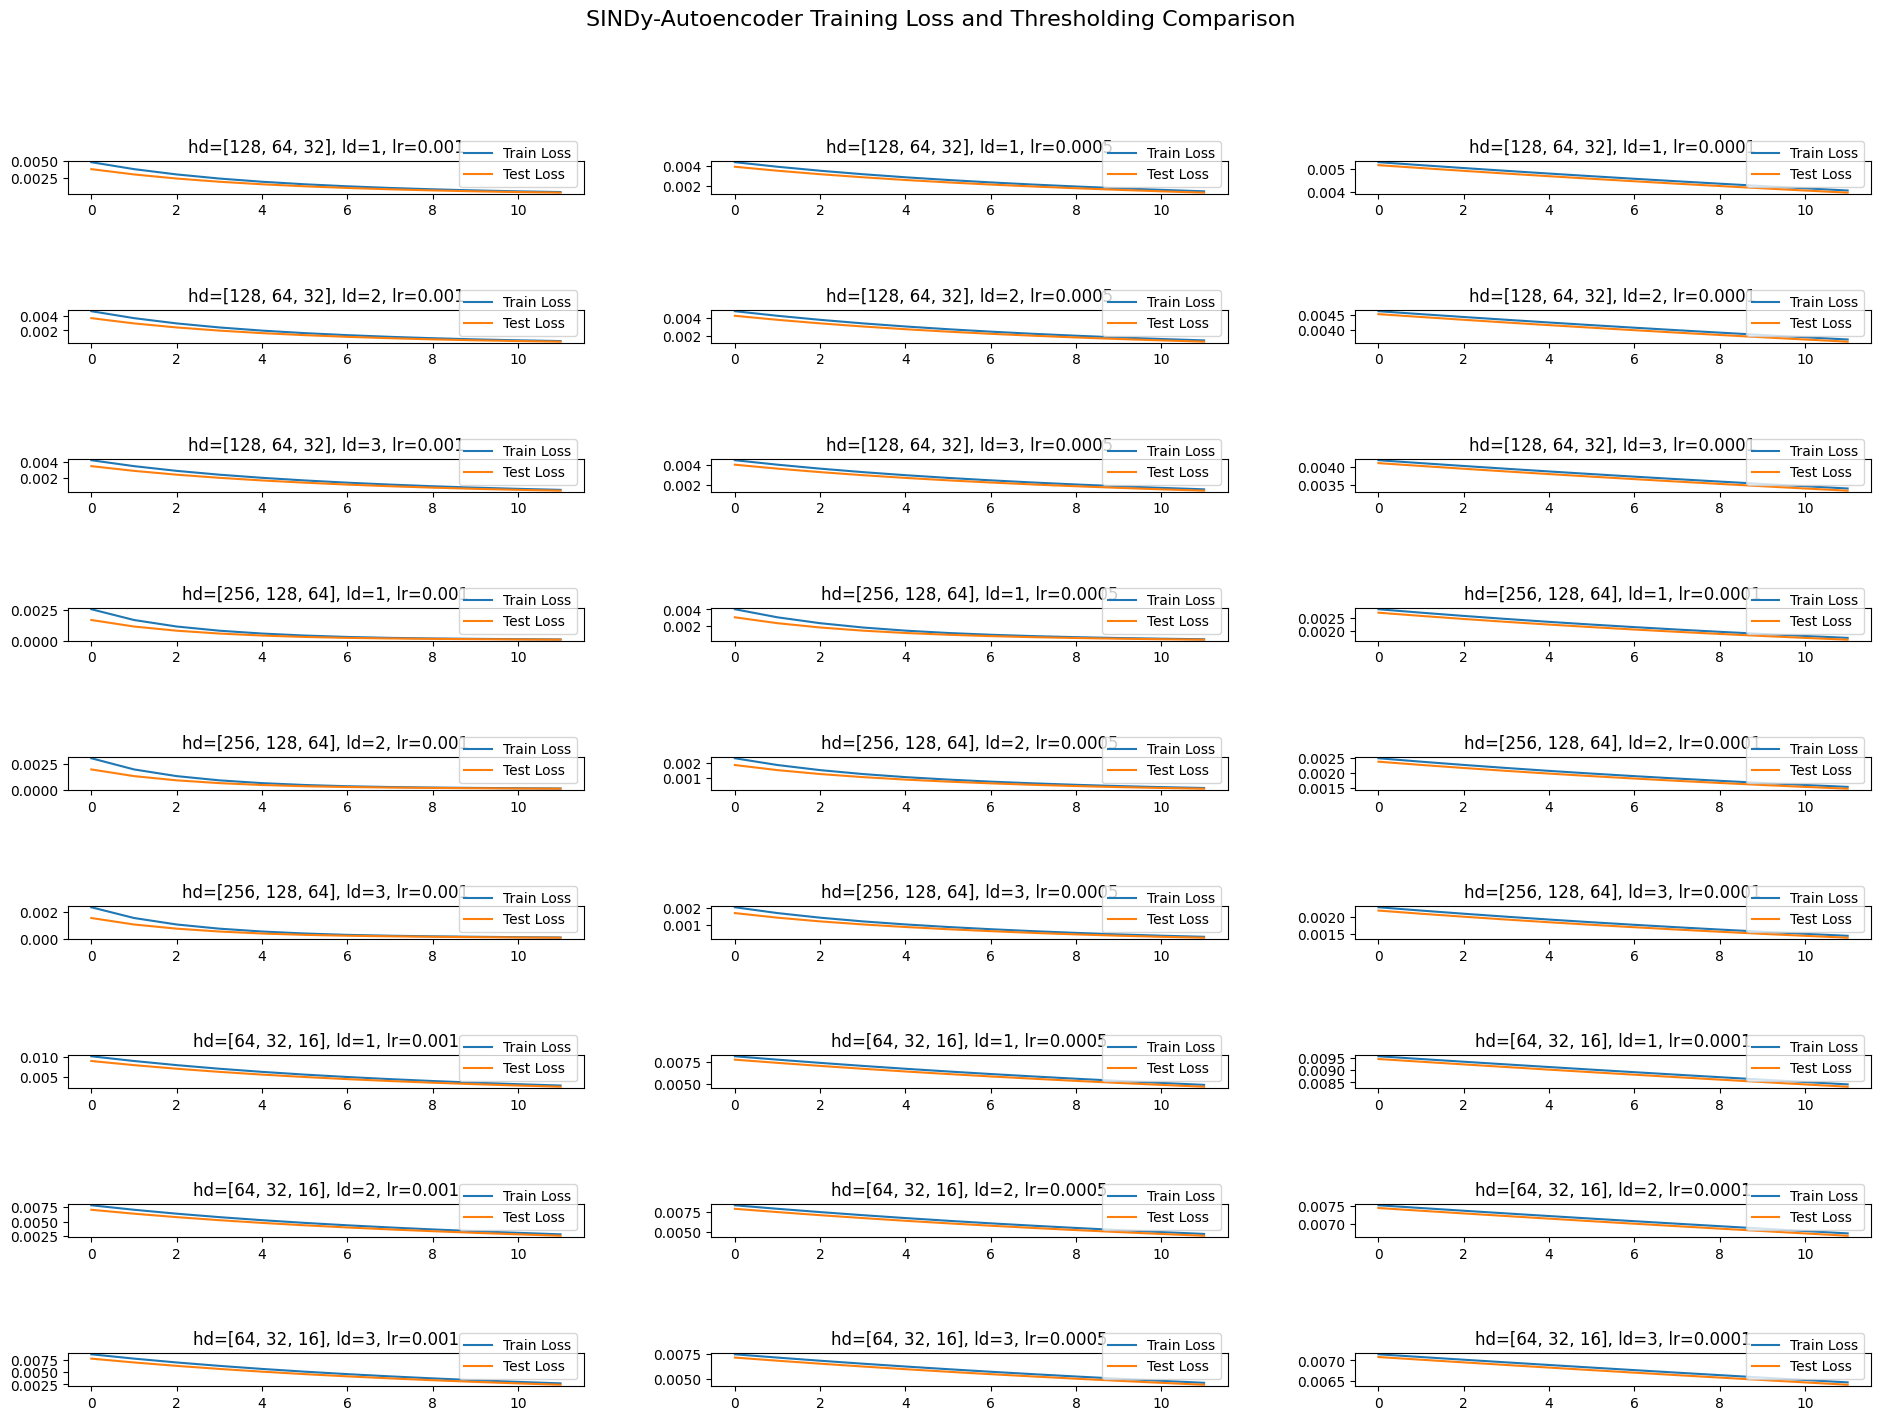

In [9]:
## 3.4 Evaluation: Comparing ST and PTAT

# Sequential Thresholding (ST) function
def sequential_thresholding(latent_representations, threshold=0.05):
    """
    Applies sequential thresholding by setting values below a certain threshold to zero.
    """
    return np.where(np.abs(latent_representations) > threshold, latent_representations, 0)

# Patient Trend-Aware Thresholding (PTAT) function
def ptat_thresholding(latent_representations, alpha=0.1):
    """
    Applies PTAT smoothing by computing a weighted moving average.
    """
    smoothed = np.zeros_like(latent_representations)
    for i in range(1, len(latent_representations)):
        smoothed[i] = alpha * latent_representations[i] + (1 - alpha) * smoothed[i-1]
    return smoothed

# Run experiments with ST and PTAT evaluation
results = {}
for hidden_dims in hidden_dims_list:
    for latent_dim in latent_dims:
        for lr in learning_rates:
            print(f"Training with hidden_dims={hidden_dims}, latent_dim={latent_dim}, lr={lr}")
            model = SINDyAutoencoder(image_resolution**2, hidden_dims, latent_dim)
            train_losses, test_losses = train_model(model, data_images_train, data_images_test, image_resolution**2, epochs=12, lr=lr)

            # Obtain latent space representations
            latent_space = model.encoder(torch.tensor(data_images_train, dtype=torch.float32).view(-1, image_resolution**2)).detach().numpy()

            # Apply thresholding methods
            st_results = sequential_thresholding(latent_space)
            ptat_results = ptat_thresholding(latent_space)

            # Store results
            results[f"hd={hidden_dims}_ld={latent_dim}_lr={lr}"] = (train_losses, test_losses, st_results, ptat_results)

# Plot results in grid layout
num_rows, num_cols = len(hidden_dims_list) * len(latent_dims), len(learning_rates)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
fig.suptitle("SINDy-Autoencoder Training Loss and Thresholding Comparison", fontsize=16)

row = 0
for hidden_dims in hidden_dims_list:
    for latent_dim in latent_dims:
        col = 0
        for lr in learning_rates:
            key = f"hd={hidden_dims}_ld={latent_dim}_lr={lr}"
            train_losses, test_losses, st_results, ptat_results = results[key]
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.plot(train_losses, label="Train Loss")
            ax.plot(test_losses, label="Test Loss")
            ax.set_title(f"hd={hidden_dims}, ld={latent_dim}, lr={lr}")
            ax.legend()
            col += 1
        row += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout(pad=5.0)
plt.show()


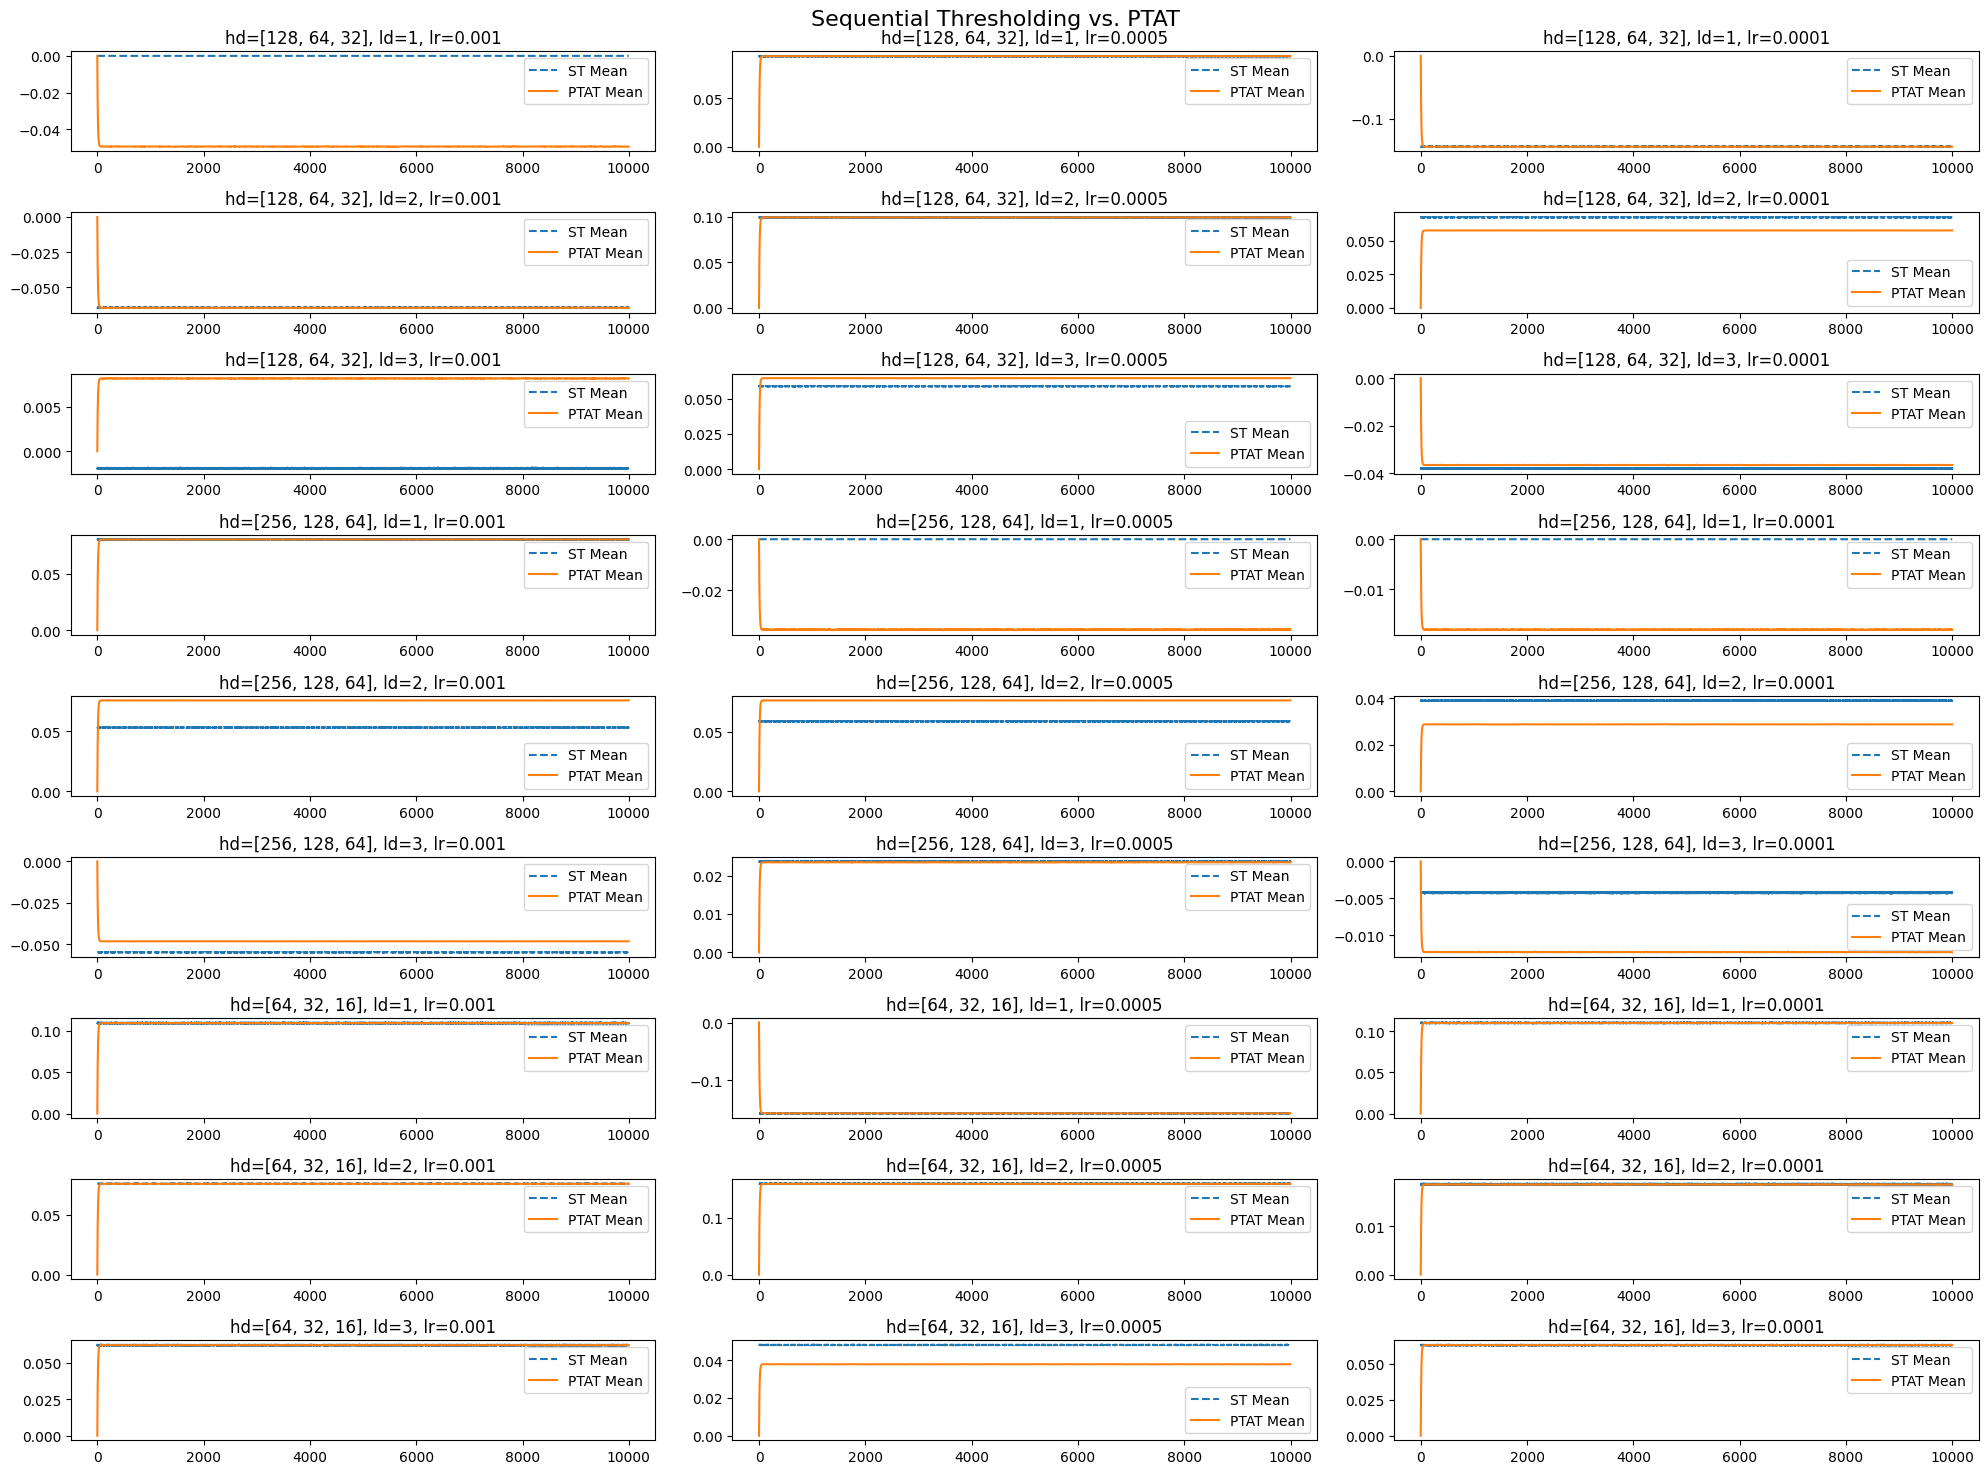

In [10]:
# Visualizing ST and PTAT thresholding
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
fig.suptitle("Sequential Thresholding vs. PTAT", fontsize=16)

row = 0
for hidden_dims in hidden_dims_list:
    for latent_dim in latent_dims:
        col = 0
        for lr in learning_rates:
            key = f"hd={hidden_dims}_ld={latent_dim}_lr={lr}"
            _, _, st_results, ptat_results = results[key]

            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.plot(st_results.mean(axis=1), label="ST Mean", linestyle='dashed')
            ax.plot(ptat_results.mean(axis=1), label="PTAT Mean", linestyle='solid')
            ax.set_title(f"hd={hidden_dims}, ld={latent_dim}, lr={lr}")
            ax.legend()
            col += 1
        row += 1

plt.tight_layout()
plt.show()
